# **Predicting arrests in Chicago crimes datasts**


## **Intro**

The main goal of this project is to predict whether a crime in the city of Chicago will result in arrest given it's report.
The project is based on the "Crimes in Chicago" dataset provided by the City of Chicago. The dataset include crime incident reports filled by the Chicago Police Department throug the years of 2012 - 2017. The reports include all crime reports occurred in the City of Chicago, excluding murder cases wich were seperated to another dataset.


## **The Dataset**

The Dataset includes 1456714 reports, each includes 22 features that contains the information regarding the crime occurred. This information can be roughly divided into the following types:

General information:

* **ID** - Unique identifier for the report.

* **Case Number** - Unique identifier for the incident (there can be multiple reports for the same incident).

* **Primary Type** - The primary description of the type of the crime occurred.

* **FBI Code** - Indicates the crime classification as outlined in the FBI.

* **IUCR** - The primary type unique code.

* **Description** - The secondary description of the type of crime.

* **Location Description** - Description of the location where the incident occurred.

* **Domestic** - Boolean indicates whether the incident was domestic-related.

Location of the crime:

* **Block** - The address where the incident occurred.



* **Beat** - Indicates the beat where the incident occurred. A beat is the smallest police geographic area.

* **District** - Indicates the police district where the incident occurred.

* **Ward** - The City Council district where the incident occurred.

* **Community Area** - The community area where the incident occurred. 

* **X Coordinate** - The x coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 

* **Y Coordinate** - The y coordinate of the location where the incident occurred in State Plane Illinois East NAD 1983 projection. 

* **Latitude** - The latitude of the location where the incident occurred.

* **Longitude** - The longitude of the location where the incident occurred. 

* **Location** - The location where the incident occurred (Longtitude, Latitude).


Time information:

* **Date** - Date when the incident occurred.

* **Year** - Year the incident occurred.

* **Updated On** - Date in which the record was last updated.


Lastly, our target is a Boolean feature indicating whether an arrest was occurred:

* **Arrest** - Indicates whether an arrest was made.

## **Data Exploration**

First, Lets import the dataset and see that it is compatible with our expectation.

In [ ]:
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
sns.set(font_scale=1.2,rc={'figure.figsize':(11,9)})
sns.set_style('white')

def load_data(file_name):
    return pd.read_csv(file_name)



In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = load_data('/content/drive/MyDrive/203/Chicago_Crimes_2012_to_2017.csv')
df.head()


,Unnamed: 0,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,89,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,197,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,673,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,911,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15.0,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [ ]:
print("Dataset shape:", df.shape)


Dataset shape: (1456714, 23)


As we can see, all features are present including the index column of the csv. Since we will not use features that do not add information regarding the crime, we can select features to drop by viewing their unique values - if the number of unique values is close to the number of samples, we drop it. In addition, we can drop 'Location' since it is a combination of the 'Latitude' and 'Longitude' features, and 'Updated On' since it is irrelevant to the crime.

In [ ]:
print(df.nunique())
df = df.drop(columns=['Unnamed: 0','ID','Case Number','Location','Updated On'])

Unnamed: 0              1456714
ID                      1456714
Case Number             1456598
Date                     582146
Block                     32774
IUCR                        365
Primary Type                 33
Description                 342
Location Description        142
Arrest                        2
Domestic                      2
Beat                        302
District                     24
Ward                         50
Community Area               78
FBI Code                     26
X Coordinate              67714
Y Coordinate             111555
Year                          6
Updated On                  959
Latitude                 368076
Longitude                367942
Location                 368286
dtype: int64


Next, we would like to check if there is a ny data missig

Date                    0.000000
Block                   0.000000
IUCR                    0.000000
Primary Type            0.000000
Description             0.000000
Location Description    0.113818
Arrest                  0.000000
Domestic                0.000000
Beat                    0.000000
District                0.000069
Ward                    0.000961
Community Area          0.002746
FBI Code                0.000000
X Coordinate            2.545661
Y Coordinate            2.545661
Year                    0.000000
Latitude                2.545661
Longitude               2.545661
dtype: float64

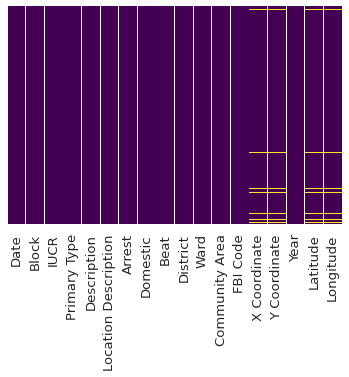

In [ ]:
display(df.isnull().mean() * 100)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

As we can observe, there is a match between the number of missing data in multiple location features, which means that the data probably missing from the same rows. We can ensure that by viewing some rows with missing data

In [ ]:
df[df['X Coordinate'].isnull()].head()

,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Latitude,Longitude
154,01/01/2015 12:00:00 AM,073XX S EXCHANGE AVE,0281,CRIM SEXUAL ASSAULT,NON-AGGRAVATED,NURSING HOME/RETIREMENT HOME,False,False,334,3.0,7.0,43.0,02,NaN,NaN,2015,NaN,NaN
155,03/21/2016 09:00:00 AM,082XX S MARSHFIELD AVE,1150,DECEPTIVE PRACTICE,CREDIT CARD FRAUD,ATM (AUTOMATIC TELLER MACHINE),False,False,614,6.0,21.0,71.0,11,NaN,NaN,2016,NaN,NaN
156,04/01/2016 03:00:00 PM,061XX S DREXEL AVE,0810,THEFT,OVER $500,RESIDENCE,False,False,313,3.0,20.0,42.0,06,NaN,NaN,2016,NaN,NaN
157,11/24/2015 05:30:00 PM,033XX W ADAMS ST,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,1124,11.0,28.0,27.0,06,NaN,NaN,2015,NaN,NaN
158,04/01/2016 12:30:00 PM,030XX W ARMITAGE AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,RESIDENCE,False,True,1421,14.0,35.0,22.0,26,NaN,NaN,2016,NaN,NaN


Since the missing data is only ~2.5% of samples, we can drop the whole rows with missing data.

In [ ]:
df = df.dropna()
df.shape

(1418365, 18)

Next, lets view some general statistics of our data.

First, We would like to explore our target, which is a boolean variable - arrested/ not arrested. We can see that the data is not balanced and only ~25% of crimes end up in arrest. We will deal with that when we split the data for training and testing.

In [ ]:
df.Arrest.mean()

0.26160896525224464

Now, Lets see the types of all of our features. We have multiple numerical features, two booleans, and the 'object' features are cateorical. For our analysis and classification, we will have to convert the boolean and categorical features later.

In [ ]:
df.dtypes

Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                float64
Ward                    float64
Community Area          float64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Latitude                float64
Longitude               float64
dtype: object

On the next sections, we will give a deeper exploration of the data by looking at the different types of data separately – general features, location features and time features.



## **General features**



The general features are fatures that give description regarding the type of crime occurred. As we can see, we have 6 features. Most of them are categorical, excluding the ‘Domestic’ features which is Boolean.

In [ ]:
Gen_cols = ['FBI Code','Primary Type','IUCR','Description','Location Description','Domestic']
df[Gen_cols].dtypes

FBI Code                object
Primary Type            object
IUCR                    object
Description             object
Location Description    object
Domestic                  bool
dtype: object

Before continuing, we can take a look at the general statistics of these featurs:

In [ ]:
df.describe()

,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Year,Latitude,Longitude
count,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06
mean,1.150282e+03,1.125518e+01,2.285474e+01,3.747455e+01,1.164399e+06,1.885510e+06,2.013851e+03,4.184144e+01,-8.767223e+01
std,6.916395e+02,6.904508e+00,1.379378e+01,2.142995e+01,1.843389e+04,3.413940e+04,1.423228e+00,9.399956e-02,6.637181e-02
min,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.012000e+03,3.661945e+01,-9.168657e+01
25%,6.130000e+02,6.000000e+00,1.000000e+01,2.300000e+01,1.152540e+06,1.858752e+06,2.013000e+03,4.176784e+01,-8.771529e+01
50%,1.024000e+03,1.000000e+01,2.300000e+01,3.200000e+01,1.166015e+06,1.891485e+06,2.014000e+03,4.185787e+01,-8.766614e+01
75%,1.711000e+03,1.700000e+01,3.400000e+01,5.700000e+01,1.176363e+06,1.908687e+06,2.015000e+03,4.190524e+01,-8.762812e+01
max,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951573e+06,2.017000e+03,4.202271e+01,-8.752453e+01


Since our features are categorical, we will need to convert them to numerical values for analysis and later classification. We note that the order of the features does not have any meaning. Thus, we can create numerical encoding by using target encoding – encoding according to the mean of the arrest in each category. These will give us the best numerical codes for the later classification, since the encoding considers the relationship with the target.

In [ ]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 451 kB/s 


In [ ]:
from category_encoders import TargetEncoder
Targetenc = TargetEncoder()
df_encoded = Targetenc.fit_transform(X = df[Gen_cols], y = df.Arrest)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In additionm since our target is a boolean variable - arrested/ not arrested, we will turn all boolean features to numerical (-1/1) for the furthur analysis of corellations:

In [ ]:
bool_cols = df.select_dtypes(['bool']).columns
df[bool_cols + '_num'] = df[bool_cols].applymap(lambda x: 1 if x==True else -1)

In [ ]:
def correlation_with_target(df,target):
  for col in df:
    print(col,target.corr(df[col]))

Lets see how our features correlate with the target: 

In [ ]:
correlation_with_target(df_encoded,df.Arrest_num)

FBI Code 0.6315178785909955
Primary Type 0.6535702744676951
IUCR 0.7328804850944703
Description 0.730896130520474
Location Description 0.3017385711554071
Domestic -0.06275097852975875


Many features have quite high correlation with the target! Lets explore the ones that has meaning to see if we can get some conclusions regarding the high factors that influence arrest probability.

First, lets look at the primary type.

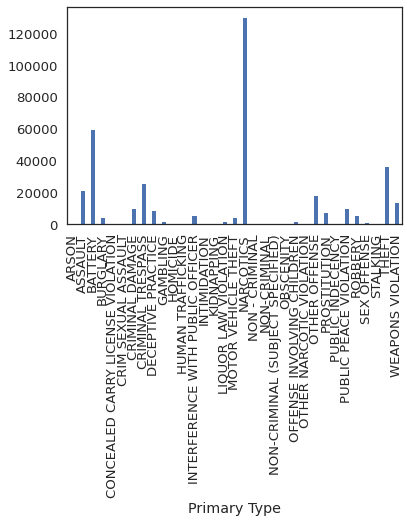

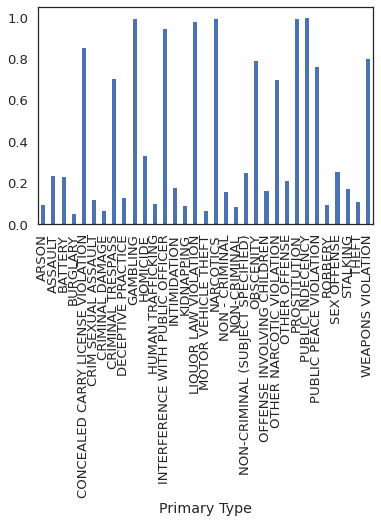

In [ ]:
df.groupby([df['Primary Type']]).Arrest.sum().plot(kind='bar')
plt.show()
df.groupby([df['Primary Type']]).Arrest.mean().plot(kind='bar')
plt.show()

Many crimes that end up with arrest are related to narcotics, assault and theft.

Lats take a look at the desription. Since this category has many values, we will plot only top 30:

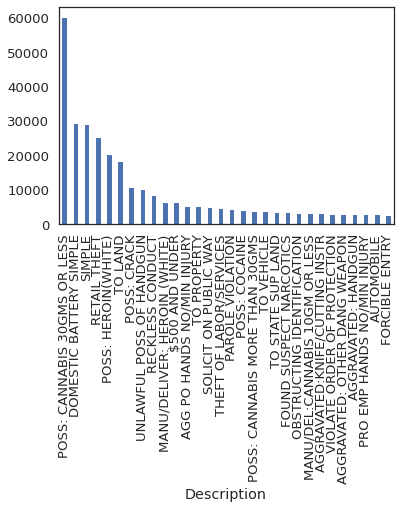

In [ ]:
df.groupby([df['Description']]).Arrest.sum().nlargest(30).plot(kind='bar')
plt.show()


Here again we can see that many crime are desribed by possetions of different narcotics. These two features are probability correlated at some degree. We will test that soon. 

We would also like to check the ‘Domestic’ feature. It has low correlation with our target:

Arreest ratio: Domestic
False    0.273271
True     0.196385
dtype: float64


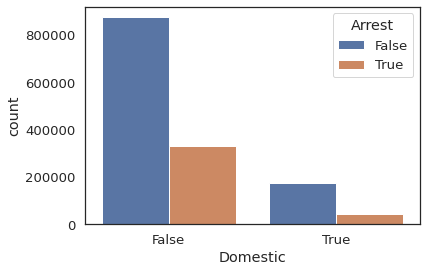

In [ ]:
print("Arreest ratio:",df.groupby([df['Domestic']]).Arrest.sum()/df.groupby([df['Domestic']]).size())
sns.countplot(data=df,x='Domestic',hue='Arrest')
plt.show()


Indeed, the ratio between arrests and non-arrests of the two categories is quite close. However, since non-domestic crimes has higher ratio, we will keep it.


Now, lets look how the features correlate with each other:

In [ ]:
def plot_correlations(df):

  corr= df.corr()
  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr, dtype=bool))

  # Set up the matplotlib figure
  f, ax = plt.subplots(figsize=(11, 9))

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)
  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)

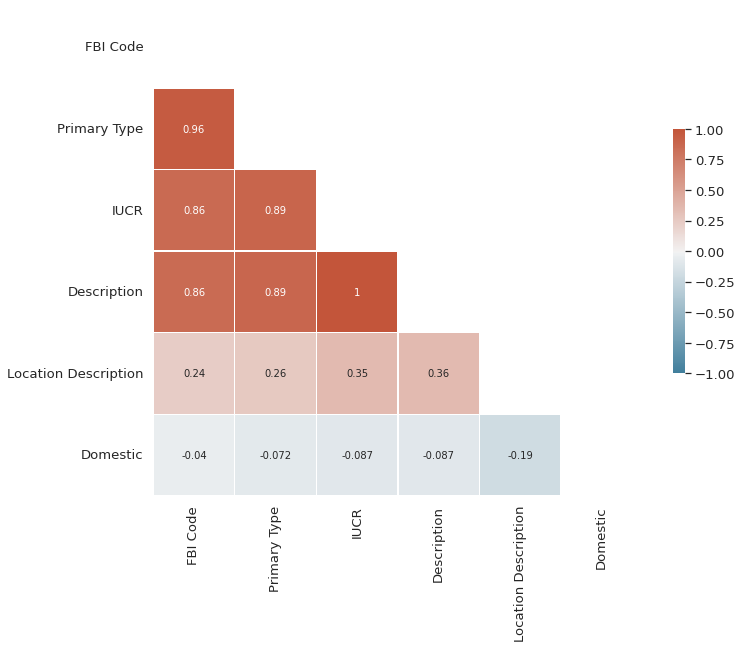

In [ ]:
plot_correlations(df_encoded)

‘Primary type’ and ‘FBI Code’ are highly correlated, probably since the code describes the crime type. In addition the ‘description’ and ‘IUCR’ are perfectly correlated, probably for the same reason. Let plot the to see their relationship:

In [ ]:
def plot_2d(df,col1,col2):
  g = sns.JointGrid(data=df, x=col1, y=col2)
  g = g.plot_joint(sns.regplot, color="xkcd:muted blue",ci=None)
  g = g.plot_marginals(sns.distplot, kde=False, bins=10, color="xkcd:bluey grey")

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


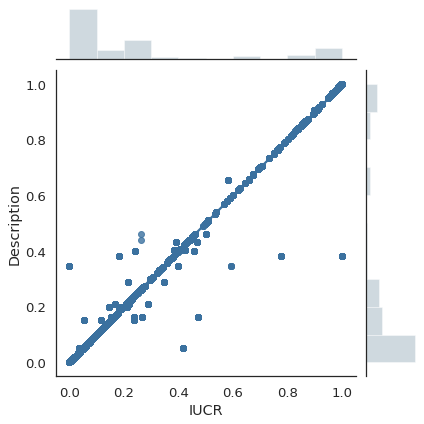

In [ ]:
plot_2d(df=df_encoded,col1='IUCR', col2='Description')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


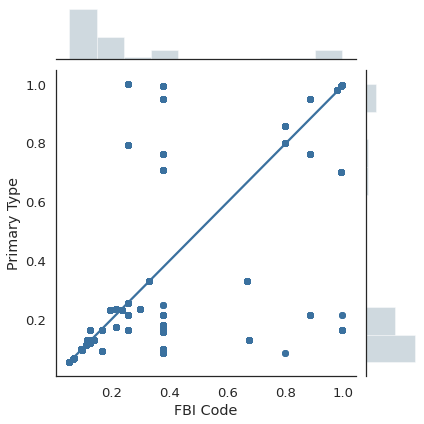

In [ ]:
plot_2d(df=df_encoded,col1='FBI Code', col2='Primary Type')

Indeed, the relationship between the features seems strong, as well as the similarity of their distribution. 

Now, lets take a look at the relationship between ‘FBI Code’ and 'IUCR', who has also a strong correlation as we expected


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


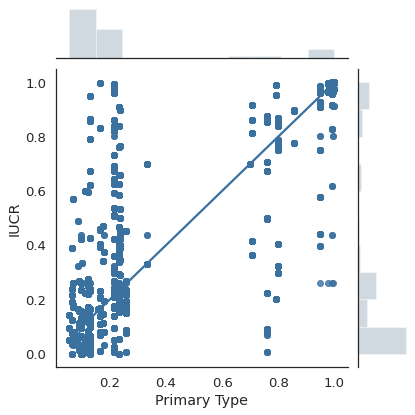

In [ ]:
plot_2d(df=df_encoded,col1='Primary Type', col2='IUCR')

The features has strong relationship, however it seams that there is some that is not shared, thus we will keep them, and drop the rest:

In [ ]:
df[Gen_cols]=df_encoded
df = df.drop(columns=['FBI Code','Description'])

## **Location features**

As we saw at the intro, there are a lot of location features. We would like to see whether there are some features that correspond with each other.


In [ ]:
Location_cols = ['Block','Beat','District','Ward','Community Area','X Coordinate','Y Coordinate','Longitude','Latitude']
df[Location_cols].dtypes

Block              object
Beat                int64
District          float64
Ward              float64
Community Area    float64
X Coordinate      float64
Y Coordinate      float64
Longitude         float64
Latitude          float64
dtype: object

The Block is a categorical variable, so we should turn them to numeric in order to check correlation.

In [ ]:
df[Location_cols[0]] = df[Location_cols[0]].astype("category")
df[Location_cols[0]] = df[Location_cols[0]].cat.codes


We can check the statistics and distibution of each of the features:

In [ ]:
df[Location_cols].describe()

,Block,Beat,District,Ward,Community Area,X Coordinate,Y Coordinate,Longitude,Latitude
count,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06,1.418365e+06
mean,1.577834e+04,1.150282e+03,1.125518e+01,2.285474e+01,3.747455e+01,1.164399e+06,1.885510e+06,-8.767223e+01,4.184144e+01
std,9.630395e+03,6.916395e+02,6.904508e+00,1.379378e+01,2.142995e+01,1.843389e+04,3.413940e+04,6.637181e-02,9.399956e-02
min,0.000000e+00,1.110000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.168657e+01,3.661945e+01
25%,6.869000e+03,6.130000e+02,6.000000e+00,1.000000e+01,2.300000e+01,1.152540e+06,1.858752e+06,-8.771529e+01,4.176784e+01
50%,1.594600e+04,1.024000e+03,1.000000e+01,2.300000e+01,3.200000e+01,1.166015e+06,1.891485e+06,-8.766614e+01,4.185787e+01
75%,2.466100e+04,1.711000e+03,1.700000e+01,3.400000e+01,5.700000e+01,1.176363e+06,1.908687e+06,-8.762812e+01,4.190524e+01
max,3.254500e+04,2.535000e+03,3.100000e+01,5.000000e+01,7.700000e+01,1.205119e+06,1.951573e+06,-8.752453e+01,4.202271e+01


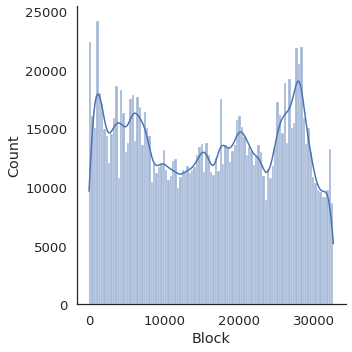

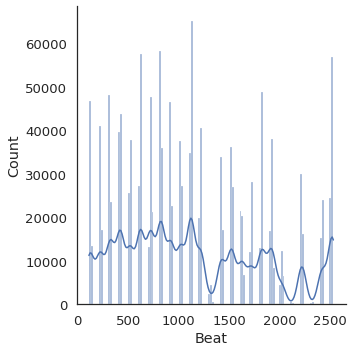

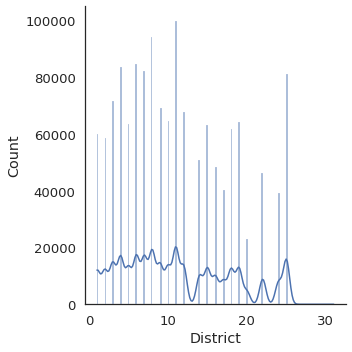

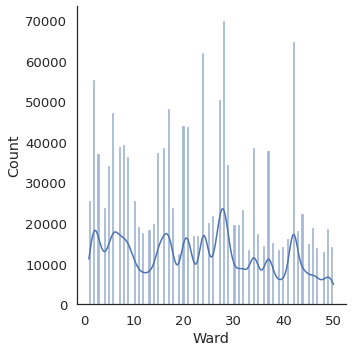

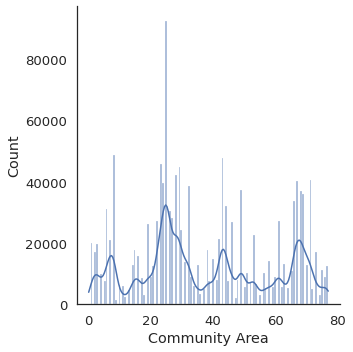

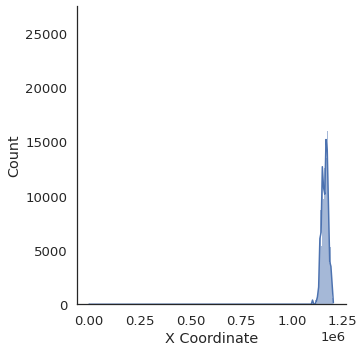

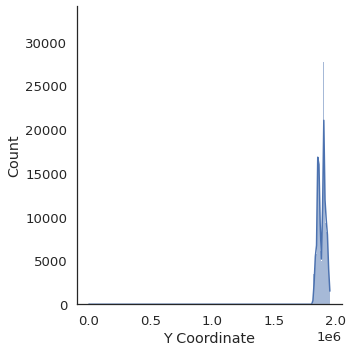

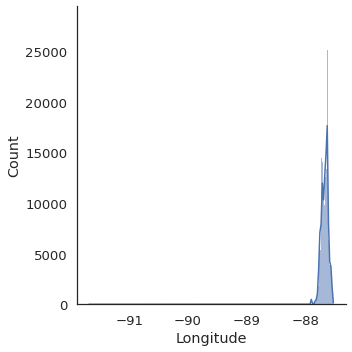

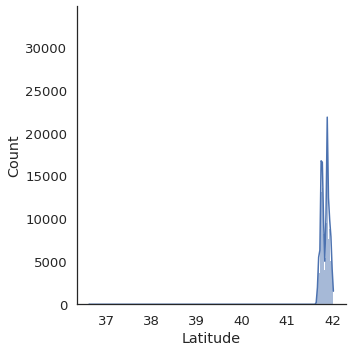

In [ ]:
for col in Location_cols:
  sns.displot(df[col], kde=True)
  plt.show()

As we can observe, the distribution of the last four locations is very skewed, lets try to remove outliers by removing rows in the lower 0.01% data:

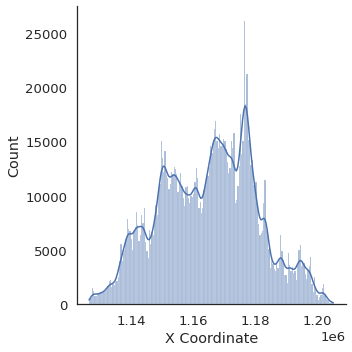

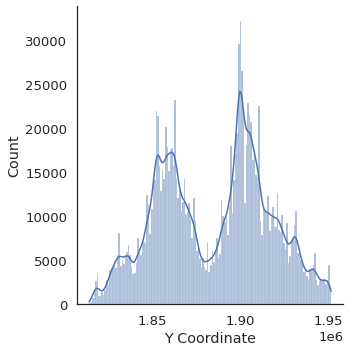

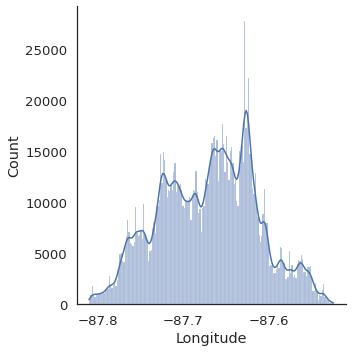

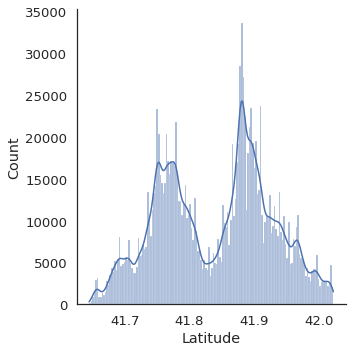

In [ ]:
df = df[df.Longitude>df.Longitude.quantile(0.01)]
for col in Location_cols[-4:]:
  sns.displot(df[col], kde=True)
  plt.show()

This looks better.
Now, we can compute the correlation between the features in order to check for dependencies:

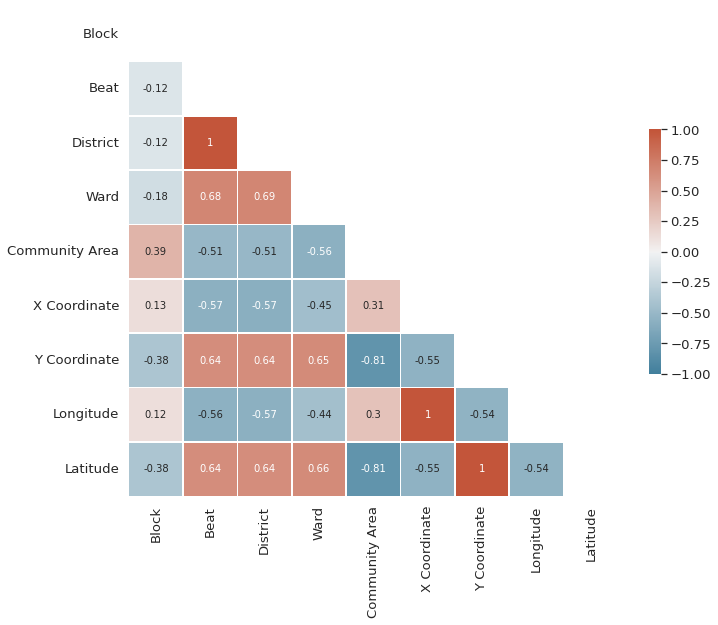

In [ ]:
plot_correlations(df[Location_cols])

As we can see, X coordinate and Longtitude, Y coordinate and Latitude and Distrcit and Beat are perfectly correlated, probably since they are just different ways of describing location:




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


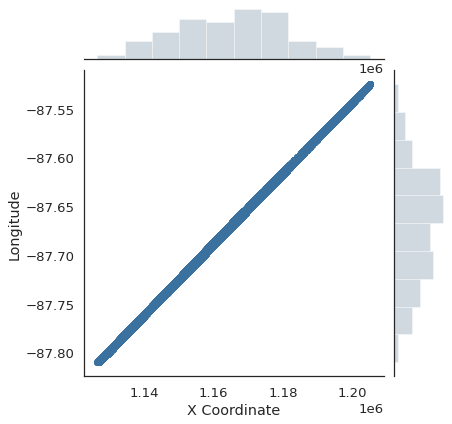

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


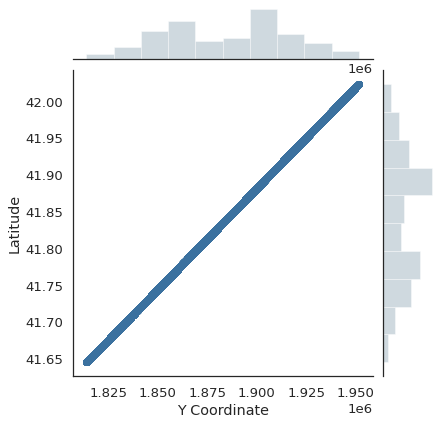

In [ ]:
plot_2d(df=df,col1='X Coordinate', col2='Longitude')
plt.show()
plot_2d(df=df,col1='Y Coordinate', col2='Latitude')



In addition, ‘Beat’ and ‘District’ are also highly correlated:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


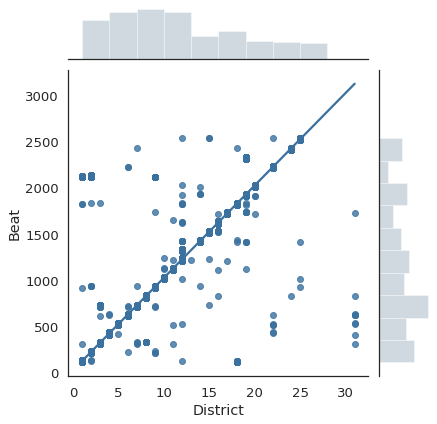

In [ ]:
plot_2d(df=df,col1='District', col2='Beat')

Here, it is hard to tell based on the scatter plot. We can take a look at a binned plot:

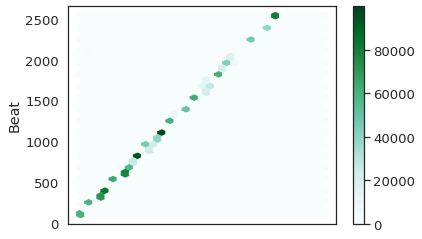

In [ ]:
df.plot.hexbin(x='District', y='Beat',gridsize=30)

We will remove "X coordinate", "Y coordinate" and "District" (since Beat has more information than District).


In [ ]:
to_remove = ['X Coordinate', 'Y Coordinate','District']
df = df.drop(columns=to_remove)
for item in to_remove:
  Location_cols.remove(item)

Now, let's take a look at the correlation with the target:

In [ ]:
correlation_with_target(df[Location_cols],df['Arrest_num'])

Block -0.022173545570708164
Beat -0.020461265518906507
Ward -0.008601150016556217
Community Area 0.015801875979751967
Longitude -0.04115050862955314
Latitude -0.019399928697897473


We will remove 'Ward' since it has low correlation with the target and high correlation with the district:

In [ ]:
df = df.drop(columns='Ward')


We can view the arrests mean as a function of geographic area. As we can see, some areas of Chicago has higher arrests mean:

---



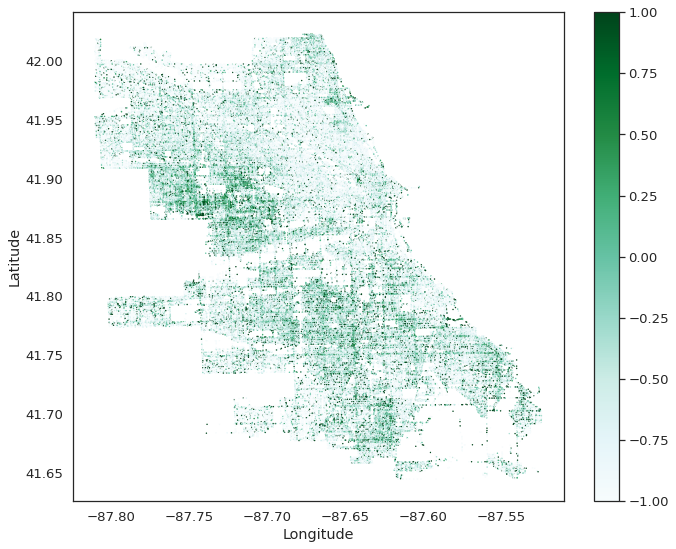

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))

df.plot.hexbin(x="Longitude", y="Latitude", C="Arrest_num", reduce_C_function=np.mean, gridsize=1000,ax=ax);

Since this map is quite specified, we can decrease the grid size and see the relationship between arrests mean and bigger geographic areas:

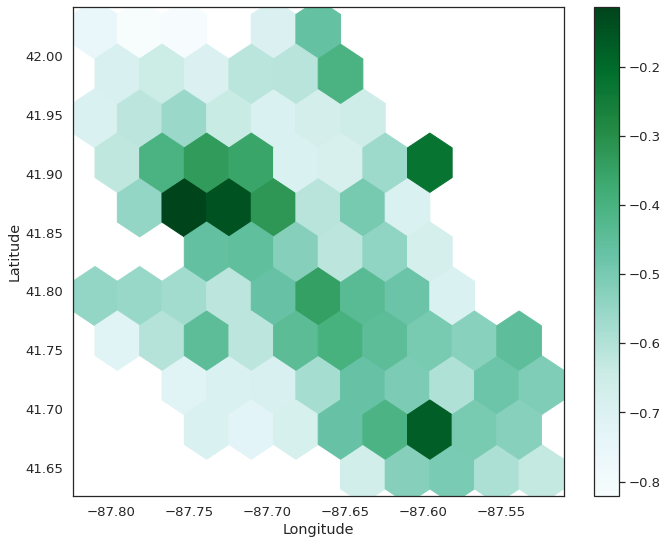

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))

df.plot.hexbin(x="Longitude", y="Latitude", C="Arrest_num", reduce_C_function=np.mean, gridsize=10,ax=ax);

The information regarding bigger geographical areas might be present in other features. However, we can use "cut" to create new features that capture area range, which might be better for later classification:

In [ ]:
def create_group(df,col):
    group=pd.cut(df[col],bins=10,labels = range(10))

    df[col+'Group']=group.astype('int')
    return df

In [ ]:
df= create_group(df,'Longitude')
df = create_group(df,'Latitude')
#df['y group'] = pd.cut(df['Latitude'],1000)[0]


## **Time Features**

All information regarding the time of the crime is kept in the "Date Field". We would like to split it and extract as much information as possible. We can do this by first converting the "Date" column to datetime type and then get our features of interest.

In [ ]:
df['Date']= pd.to_datetime(df['Date'])


We can sort the crime according to the date in order to plot the arrests as a function of time.

In [ ]:
df_time = df.set_index('Date')
df_time = df_time.sort_index()


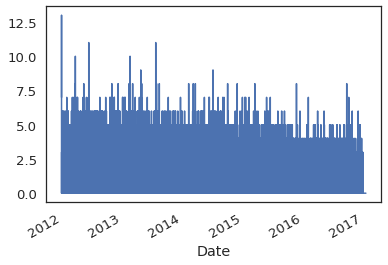

In [ ]:
df.groupby('Date').Arrest.sum().plot()

As we can observe, there are some frequency patterns in the data. We need to split the data to understand these.

We will choose month, day, day of week and hour.

In [ ]:
df['Month'] = df['Date'].dt.month
df["day"] = df['Date'].dt.day 
df['dayofweek'] = df['Date'].dt.dayofweek
df["hour"] = df['Date'].dt.hour
df=df.drop(columns="Date")

Lets view the arrests mean as a function of all time features:

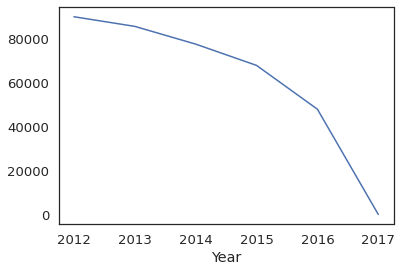

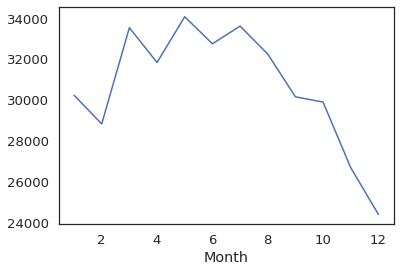

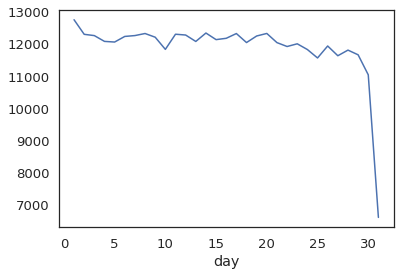

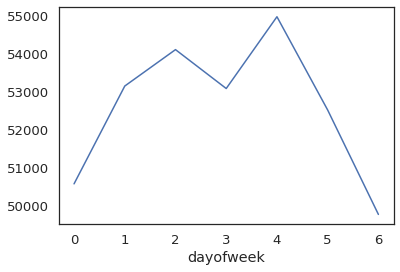

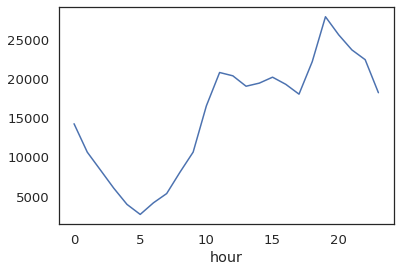

In [ ]:
df.groupby('Year').Arrest.sum().plot()
plt.show()
df.groupby('Month').Arrest.sum().plot()
plt.show()
df.groupby('day').Arrest.sum().plot()
plt.show()
df.groupby('dayofweek').Arrest.sum().plot()
plt.show()
df.groupby('hour').Arrest.sum().plot()

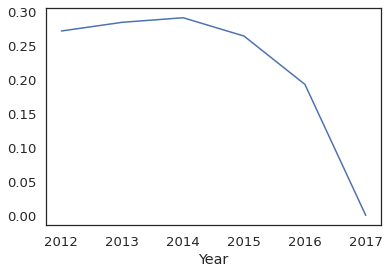

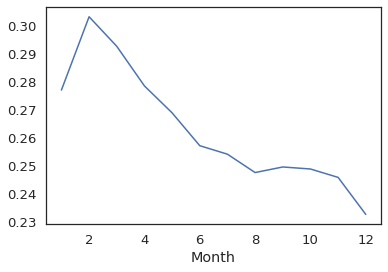

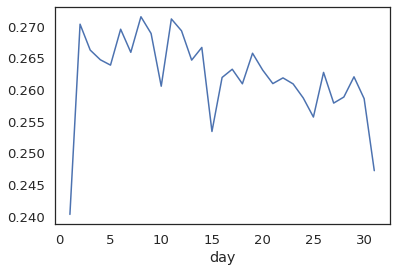

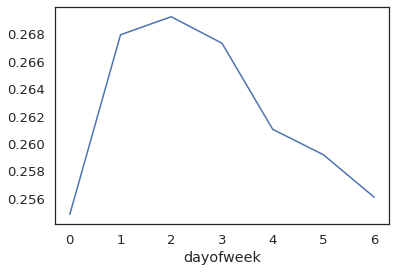

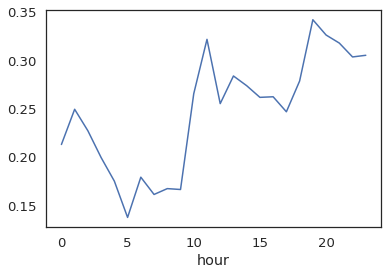

In [ ]:
df.groupby('Year').Arrest.mean().plot()
plt.show()
df.groupby('Month').Arrest.mean().plot()
plt.show()
df.groupby('day').Arrest.mean().plot()
plt.show()
df.groupby('dayofweek').Arrest.mean().plot()
plt.show()
df.groupby('hour').Arrest.mean().plot()

As one might expect, there are more arrests for crime that occur during night. In addition, arrest mean decreaed through the years. Arrests increase for crimes occured during Sunday and the beggining of the week, as well as the middle of the month. Finally, The day of the month has lower relationship with arrests mean, and the decrease at the end might be related to the number of days per month. 

# **Classification**

## **Naive Bayse**

We need to seperate the target from the data:

In [ ]:
df=df.drop(columns=['Arrest','Domestic'])
Target = df.pop('Arrest_num')
df.head()

,Block,IUCR,Primary Type,Location Description,Beat,Community Area,Year,Latitude,Longitude,Domestic_num,LongitudeGroup,LatitudeGroup,Month,day,dayofweek,hour
0,6452,0.228807,0.231709,0.170454,1022,29.0,2016,41.864073,-87.706819,1,3,5,5,3,1,23
1,24340,0.228807,0.231709,0.127458,313,42.0,2016,41.782922,-87.604363,1,7,3,5,3,1,21
2,21841,0.873951,0.761429,0.254805,1524,25.0,2016,41.894908,-87.758372,-1,1,6,5,3,1,23
3,20464,0.210302,0.231709,0.482168,1532,25.0,2016,41.885687,-87.749516,-1,2,6,5,3,1,22
4,1909,0.048875,0.112754,0.127458,1523,25.0,2016,41.886297,-87.761751,1,1,6,5,3,1,22


Now we need to split the data for train and test. Since the data is imbalanced, we will use the ‘stratify’ option:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, Target, random_state=0,stratify=Target)

Lets fit the model with all features in order to get the feature importance:

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 87.55205870455724


We can get feature importance by using ‘Permutation importance’:

In [ ]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(gnb, X_test, y_test)
importances = imps.importances_mean
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for f in range(X_test.shape[1]):
    print("%d. %s (%f)" % (f + 1, df.columns[indices[f]], importances[indices[f]]))

Feature ranking:
1. IUCR (0.103472)
2. Primary Type (0.057977)
3. Domestic_num (0.000566)
4. Location Description (0.000330)
5. Year (0.000306)
6. Month (0.000097)
7. Community Area (0.000070)
8. hour (0.000066)
9. LatitudeGroup (0.000059)
10. Block (0.000017)
11. LongitudeGroup (0.000007)
12. Latitude (0.000006)
13. Beat (0.000005)
14. dayofweek (-0.000007)
15. Longitude (-0.000014)
16. day (-0.000028)


As expected, the most important features are the one that had the highest correlation with the target. Now lets fit the model with the top two features:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[df.columns[[1,2]]], Target, random_state=0,stratify=Target)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

from sklearn import metrics
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 88.16252001162242


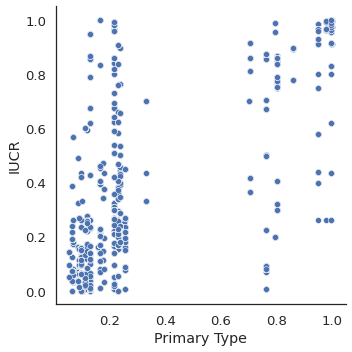

In [ ]:
sns.relplot(x=df['Primary Type'],y=df['IUCR'])

We note that the two features has some complementary information!

## **Baseline Desition Tree**

To create a baseline desition tree we need to import the raw data again, split the target and convert categorical features to numerical.

In [ ]:
df_raw = load_data('/content/drive/MyDrive/203/Chicago_Crimes_2012_to_2017.csv')
df_raw = df_raw.drop(columns=['Unnamed: 0'])
df_raw = df_raw.dropna()
df_raw.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10508693,HZ250496,05/03/2016 11:40:00 PM,013XX S SAWYER AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,True,True,1022,10.0,24.0,29.0,08B,1154907.0,1893681.0,2016,05/10/2016 03:56:50 PM,41.864073,-87.706819,"(41.864073157, -87.706818608)"
1,10508695,HZ250409,05/03/2016 09:40:00 PM,061XX S DREXEL AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,313,3.0,20.0,42.0,08B,1183066.0,1864330.0,2016,05/10/2016 03:56:50 PM,41.782922,-87.604363,"(41.782921527, -87.60436317)"
2,10508697,HZ250503,05/03/2016 11:31:00 PM,053XX W CHICAGO AVE,0470,PUBLIC PEACE VIOLATION,RECKLESS CONDUCT,STREET,False,False,1524,15.0,37.0,25.0,24,1140789.0,1904819.0,2016,05/10/2016 03:56:50 PM,41.894908,-87.758372,"(41.894908283, -87.758371958)"
3,10508698,HZ250424,05/03/2016 10:10:00 PM,049XX W FULTON ST,0460,BATTERY,SIMPLE,SIDEWALK,False,False,1532,15.0,28.0,25.0,08B,1143223.0,1901475.0,2016,05/10/2016 03:56:50 PM,41.885687,-87.749516,"(41.885686845, -87.749515983)"
4,10508699,HZ250455,05/03/2016 10:00:00 PM,003XX N LOTUS AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,True,1523,15.0,28.0,25.0,06,1139890.0,1901675.0,2016,05/10/2016 03:56:50 PM,41.886297,-87.761751,"(41.886297242, -87.761750709)"


In [ ]:
Target_raw = df_raw.pop('Arrest')
Target_raw

0           True
1          False
2          False
3          False
4          False
           ...  
1456709     True
1456710     True
1456711    False
1456712    False
1456713     True
Name: Arrest, Length: 1418365, dtype: bool

In [ ]:
obj_cols = df_raw.select_dtypes(['bool','object']).columns

df_raw[obj_cols] = df_raw[obj_cols].astype("category")
df_raw[obj_cols] = df_raw[obj_cols].apply(lambda x: x.cat.codes)
df_raw.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10508693,1243039,185476,6452,51,2,119,17,1,1022,10.0,24.0,29.0,10,1154907.0,1893681.0,2016,296,41.864073,-87.706819,192874
1,10508695,1242985,185418,24340,51,2,119,109,1,313,3.0,20.0,42.0,10,1183066.0,1864330.0,2016,296,41.782922,-87.604363,118579
2,10508697,1243045,185469,21841,42,27,264,125,0,1524,15.0,37.0,25.0,24,1140789.0,1904819.0,2016,296,41.894908,-87.758372,235137
3,10508698,1242993,185433,20464,39,2,282,121,0,1532,15.0,28.0,25.0,10,1143223.0,1901475.0,2016,296,41.885687,-87.749516,222627
4,10508699,1243013,185428,1909,84,31,0,109,1,1523,15.0,28.0,25.0,7,1139890.0,1901675.0,2016,296,41.886297,-87.761751,223487


Now we can fit the tree. 
We will check what is the best 'Max depth' parameter by searching a wide range:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_raw, Target_raw, random_state=0,stratify=Target_raw)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

max_depth_range = list(range(1, 20,2))
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)

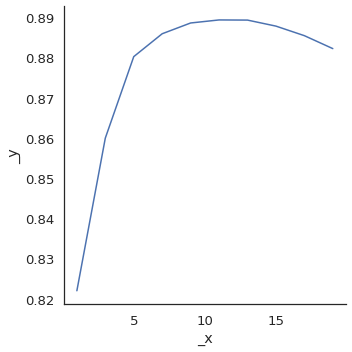

In [ ]:
sns.relplot(x=max_depth_range, y=accuracy, kind="line")

In [ ]:
print('Max accuracy:', max(accuracy))
print('Max depth:',max_depth_range[pd.Series(accuracy).argmax()])

Max accuracy: 0.8893347847667178
Max depth: 11


As we can observe, the best depth has 90% accuracy.
Lets check feature importance:

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,6)})
importances = importances.sort_values('importance',ascending=False)
importances.style

,feature,importance
13,FBI Code,0.427060
4,IUCR,0.246315
6,Description,0.116748
5,Primary Type,0.035787
7,Location Description,0.031426
2,Date,0.020813
3,Block,0.015591
1,Case Number,0.014208
0,ID,0.014177
14,X Coordinate,0.012043


Here, the second best feature is different, and it is related to the location of the crime.

Lets plot the tree, with depth of 3 for visualization convenience:

In [ ]:
from sklearn import tree
clf = DecisionTreeClassifier(max_depth = 11, random_state = 0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=11, random_state=0)

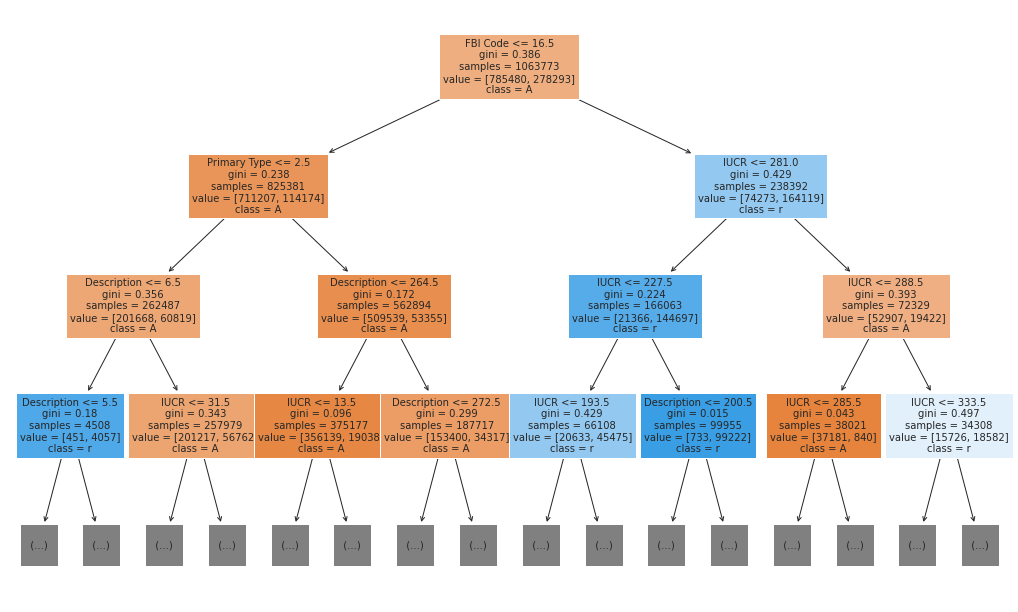

In [ ]:
plt.figure(figsize=(18,11))
tree.plot_tree(clf,feature_names=df_raw.columns, class_names='Arrest',fontsize=10,filled=True,max_depth=3);

## **Desition tree - improved**


Now we can check how the desition tree handles the processed data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, Target, random_state=0)

In [ ]:
# List of values to try for max_depth:
max_depth_range = list(range(1, 20,2))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    accuracy.append(score)

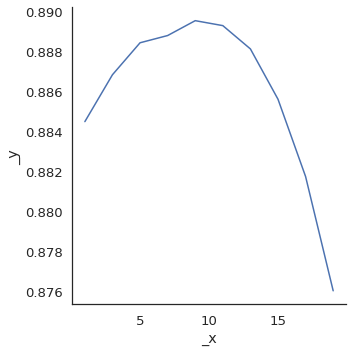

In [ ]:
sns.relplot(x=max_depth_range, y=accuracy, kind="line")

In [ ]:
print('Max accuracy:', max(accuracy))
print('Max depth:',max_depth_range[pd.Series(accuracy).argmax()])

Max accuracy: 0.8895272984167317
Max depth: 9


Unfortunately, the best depth has not improved at it has less than 90% accuracy as well. This is probably due to the complexity of the data, and a more complex model would do a better job.
Lets check if feature importance is different:

In [ ]:
importances = pd.DataFrame({'feature':X_train.columns,'importance':np.round(clf.feature_importances_,6)})
importances = importances.sort_values('importance',ascending=False)
importances.style

,feature,importance
1,IUCR,0.794425
8,Longitude,0.027321
3,Location Description,0.026630
7,Latitude,0.023187
0,Block,0.022365
13,day,0.019684
15,hour,0.019620
4,Beat,0.014899
12,Month,0.014244
14,dayofweek,0.010953


In [ ]:
clf = DecisionTreeClassifier(max_depth = 9, random_state = 0)
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=9, random_state=0)

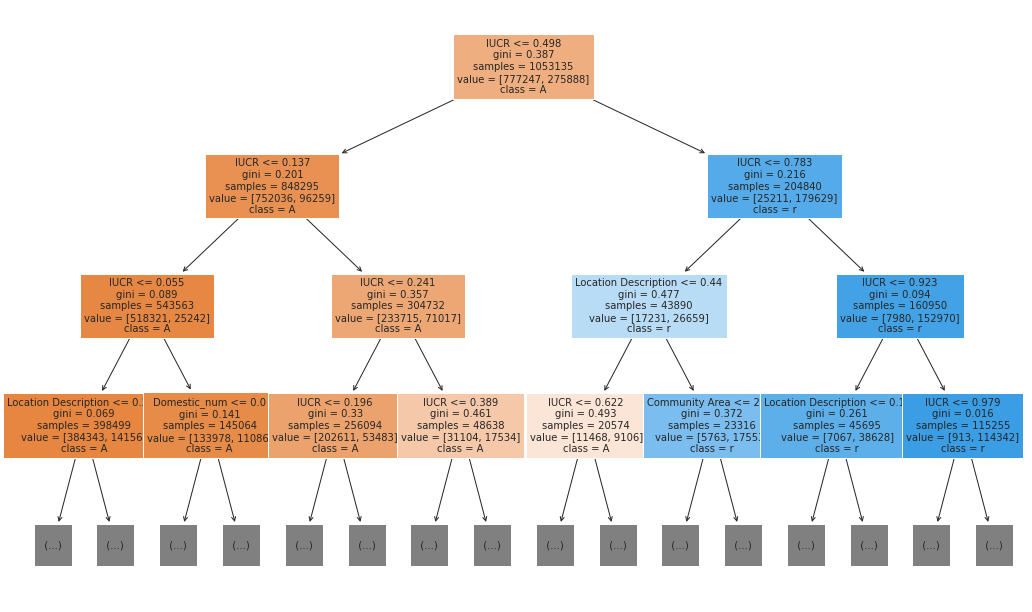

In [ ]:
plt.figure(figsize=(18,11))
tree.plot_tree(clf,feature_names=df.columns, class_names='Arrest',fontsize=10,filled=True,max_depth=3);